In [15]:
import math
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

parsing game data

In [296]:
import chess.pgn

games = []
with open("jan-13-pgns.pgn") as pgn_file:
  # while True:
  for i in range(2048):  
    game = chess.pgn.read_game(pgn_file)
    
    if game is None:
      break
    
    games.append(game)

In [297]:
print(len(games))

2048


In [298]:
games[0].mainline()

<Mainline at 0x7f9961eb5750 (1. e4 e6 2. d4 b6 3. a3 Bb7 4. Nc3 Nh6 5. Bxh6 gxh6 6. Be2 Qg5 7. Bg4 h5 8. Nf3 Qg6 9. Nh4 Qg5 10. Bxh5 Qxh4 11. Qf3 Kd8 12. Qxf7 Nc6 13. Qe8#)>

creating move lists

In [299]:
moves = []
for game in games:
  m = []
  board = game.board()
  for move in game.mainline_moves():
    m.append(board.san(move))
    board.push(move)
  m.append(game.headers["Result"])  
  
  moves.append(' '.join(m))
  
len(moves)

2048

In [300]:
moves[0]

'e4 e6 d4 b6 a3 Bb7 Nc3 Nh6 Bxh6 gxh6 Be2 Qg5 Bg4 h5 Nf3 Qg6 Nh4 Qg5 Bxh5 Qxh4 Qf3 Kd8 Qxf7 Nc6 Qe8# 1-0'

creating san to idx dictionaries

In [301]:
sans = sorted(list(set(' '.join(moves).split(' '))))
stoi = { s:i+1 for i, s in enumerate(sans) }
stoi['.'] = 0

itos = { i:s for s, i in stoi.items() }

print(len(sans))

2362


### creating datasets

In [308]:
block_size = 7 # context length

def build_dataset(moves):  
  X, Y = [], []
  for m in moves:

    #print(w)
    context = [0] * block_size
    for san in m.split(" "):
      ix = stoi[san]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(moves)
n1 = int(0.8*len(moves))
n2 = int(0.9*len(moves))

Xtr, Ytr = build_dataset(moves[:n1])
Xdev, Ydev = build_dataset(moves[n1:n2])
Xte, Yte = build_dataset(moves[n2:])

torch.Size([108463, 7]) torch.Size([108463])
torch.Size([12489, 7]) torch.Size([12489])
torch.Size([13896, 7]) torch.Size([13896])


In [309]:
num_sans = len(sans) + 1
emb_dim = 11

g = torch.Generator().manual_seed(0) # for reproducibility
C = torch.randn((num_sans, emb_dim), generator=g)
W1 = torch.randn((block_size*emb_dim, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, num_sans), generator=g)
b2 = torch.randn(num_sans, generator=g)
parameters = [C, W1, b1, W2, b2]

def calc_loss(X, Y):
  emb = C[X]
  h = torch.tanh(emb.view(-1, block_size*emb_dim) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Y)
  return loss.item()

for p in parameters:
    p.requires_grad = True

In [310]:
sum(p.nelement() for p in parameters) # number of parameters in total

272456

In [311]:
stepi = []
lossi = []
lri = []

In [312]:
lre = torch.linspace(-0.5, 0.5, 5000)
lrs = 10**lre

In [313]:
lr_opt = torch.optim.SGD(parameters, lr=1.25)  # Initialize optimizer
scheduler = torch.optim.lr_scheduler.StepLR(lr_opt, step_size=20000, gamma=0.8)

for i in range(200000):  
  # minibatch
  idxs = torch.randint(0, Xtr.shape[0], (32,))
  
  # fwd pass
  emb = C[Xtr[idxs]]
  h = torch.tanh(emb.view(-1, block_size*emb_dim) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Ytr[idxs]) # equivalent to 3 prev lines
  # print(loss.item())

  # bwd pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = lr_opt.param_groups[0]['lr']
  for p in parameters:
    p.data += -lr * p.grad
  
  # step lr
  lr_opt.step()
  scheduler.step()
  
  # track stats
  stepi.append(i)
  # lri.append(lre[i])
  lossi.append(loss.log10().item())
  
  if i % 20000 == 0:
    print(i, lr, calc_loss(Xtr, Ytr), calc_loss(Xdev, Ydev))
  
print(loss.item())

0 1.25
20000 1.0
40000 0.8
60000 0.6400000000000001
80000 0.5120000000000001
100000 0.40960000000000013
120000 0.32768000000000014
140000 0.2621440000000001
160000 0.2097152000000001
180000 0.1677721600000001
4.98065185546875


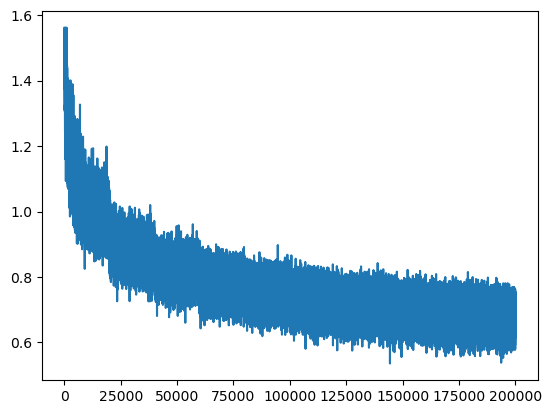

In [314]:
plt.plot(stepi, lossi)

In [319]:
print(calc_loss(Xtr, Ytr), calc_loss(Xdev, Ydev))

4.860555648803711 6.485461711883545


In [317]:
# sample from the model
g = torch.Generator().manual_seed(7)

for _ in range(1):
  out = []
  context = [0] * block_size # initialize with all ...
  while True:
    emb = C[torch.tensor([context])] # (1,block_size,d)
    h = torch.tanh(emb.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix in [1, 2, 3]:
      break
  
  print(' '.join(itos[i] for i in out))

e4 b6 b4 Qb6 g5 Bb7 Nxc6 Qd2 h5 Qxh5 Kh6 Rxd8 g7 hxg4 d5 Qxe5 Rf8 Qc1+ Rb6 Qc6+ h5 Bc5+ Bg4 Rxg5+ Rc8 Rfe7 Bxh6+ Qf3 Rxf8 O-O-O Qf6 Nxd4 Qc6 e5 fxe5 Rxf6 f4 Nxe5 Qxf5 Nxe5 Rdg8 Ka4 Qd4 Ne4 Qd4 Nc7 Rfxd8 Nh4 Bxc3 0-1


In [208]:
torch.tensor([len(g.split(" ")) for g in moves])
# len(moves[76].split(" "))


tensor([ 38,  47, 105,  44,  79,  82,  39,  98,  49,  55,  44,  63,  66, 124,
         46,  58,  78,  43,  24,  69,  78, 109,  82,  97,  43,  61, 143,  73,
         33,  47,  73,  56,  91, 140,  22, 129,  61,  76,  24,  33,  76,  30,
         26,  56,  93,  78,  87,  60,  26,  47,  69,  40, 100,  78,  77,  93,
         96,  83,  63,  53,  83,  10,  92,  42, 146,  13,  52,  74,  38,  46,
         50, 118, 107,  85, 172,  75,  50,  15,  35,  70,  68,  78,  66,  46,
         34,  64, 102,  24,  70,  72,  24, 110,  36, 118,  52,  43,  16,  56,
         47,  58, 103,  70,  66,  17, 149,  63,  57,  29,  39, 156,  44,  36,
         16,  32,  42,  82,  56,  62, 109,  25,  32,  60, 142,  22,   8,  24,
        101,  17,  24,  57,  57,  40,  70,  42, 140,  94,  50,  59,  95,  63,
         55,  43,  50,  82, 121,  52,  50,  66,  21,  42,  50,  78,  58,  75,
        132,  56,  53,  30,  56,  39,  77,  34,  38,  39,  27,  86, 108,  92,
         20,  56,  79,  68, 136,  76,  66,  70,  40,  64,  57, 1